In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

RES_DIR = "../res"
OUT_NAME = "all_experiments"

# Load experiment results

In [2]:
def load_data():
    df = pd.read_parquet(os.path.join(RES_DIR, f"{OUT_NAME}_results.parquet"))
    npz_data = np.load(os.path.join(RES_DIR, f"{OUT_NAME}_embeddings.npz"), allow_pickle=True)

    for key in ["distance", "original_image_pred_proba", "embedding_pred_proba", "modified_image_pred_proba", "modified_image", "modified_image_diff"]:
        df[key] = list(npz_data[key])

    #df.dropna(axis=1, inplace=True)
    df["input_name"] = df["input_name"].astype(str)
    return df

In [3]:
results = load_data()

In [4]:
results.head(10)

,dataset,delta_multiplier,patch_option,input_name,explored_patches,patch_attribution,number_explored_patches,save_each,algorithm,iteration,...,repetition,original_image_pred,embedding_pred,modified_image_pred,distance,original_image_pred_proba,embedding_pred_proba,modified_image_pred_proba,modified_image,modified_image_diff
0,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,0,...,1,1,1,1,[-2.6564904003206546e-21],"[0.076114856, 0.6242138, 0.29967132]","[0.07611435, 0.62421423, 0.29967147]","[0.076114826, 0.62421393, 0.29967126]",[2216],None
1,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,10,...,1,1,1,1,[4.2510478105679854e-21],"[0.076114856, 0.6242138, 0.29967132]","[0.07610984, 0.6242115, 0.29967868]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
2,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,20,...,1,1,1,1,[2.183333673113689e-23],"[0.076114856, 0.6242138, 0.29967132]","[0.07611014, 0.62421525, 0.2996746]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
3,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,30,...,1,1,1,1,[-6.0860964330541814e-21],"[0.076114856, 0.6242138, 0.29967132]","[0.07611192, 0.6242164, 0.29967168]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
4,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,40,...,1,1,1,1,[-5.5259817863972224e-21],"[0.076114856, 0.6242138, 0.29967132]","[0.07610813, 0.6242205, 0.29967132]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
5,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,50,...,1,1,1,1,[-5.959533384044208e-23],"[0.076114856, 0.6242138, 0.29967132]","[0.076106526, 0.6242089, 0.29968458]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
6,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,60,...,1,1,1,1,[-6.598275490044054e-21],"[0.076114856, 0.6242138, 0.29967132]","[0.07610746, 0.6242125, 0.29968002]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
7,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,70,...,1,1,1,1,[-4.386593354657735e-22],"[0.076114856, 0.6242138, 0.29967132]","[0.076106794, 0.62421125, 0.29968187]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
8,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,80,...,1,1,1,1,[3.6544041472244594e-20],"[0.076114856, 0.6242138, 0.29967132]","[0.07610741, 0.6242069, 0.29968572]","[0.076114826, 0.62421393, 0.29967126]",[2216],0
9,hatespeech,1.0,one,sentence_18447,[2],[1.0],1,10,simec,90,...,1,1,1,1,[-6.26987048936887e-22],"[0.076114856, 0.6242138, 0.29967132]","[0.07610722, 0.6242037, 0.29968908]","[0.076114826, 0.62421393, 0.29967126]",[2216],0


In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139380 entries, 0 to 139379
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   dataset                    139380 non-null  object 
 1   delta_multiplier           139380 non-null  float64
 2   patch_option               139380 non-null  object 
 3   input_name                 139380 non-null  object 
 4   explored_patches           139380 non-null  object 
 5   patch_attribution          119988 non-null  object 
 6   number_explored_patches    139380 non-null  int64  
 7   save_each                  139380 non-null  int64  
 8   algorithm                  139380 non-null  object 
 9   iteration                  139380 non-null  int64  
 10  delta                      139380 non-null  float64
 11  input_embedding_norm       139380 non-null  float64
 12  input_embedding_max        139380 non-null  float64
 13  time                       13

# Prediction probabilities

Is there a change in top prediction?

In [6]:
results["orig_vs_embed_diff"] = results["original_image_pred"] != results["embedding_pred"]
results["orig_vs_mod_diff"] = results["original_image_pred"] != results["modified_image_pred"]
# Initialize list
change_records = []

# Grouping columns
group_cols = ["dataset", "patch_option", "delta_multiplier", "algorithm", "input_name", "repetition"]

# Iterate over groups
for group_keys, group in results.groupby(group_cols):
    group = group.sort_values("iteration")
    rows = list(group.itertuples(index=False))

    if len(rows) < 2:
        continue

    prev_emb = rows[0].embedding_pred
    prev_mod = rows[0].modified_image_pred
    prev_emb_class_ranking = np.argsort(rows[0].embedding_pred_proba)
    prev_mod_class_ranking = np.argsort(rows[0].modified_image_pred_proba)

    for row in rows[1:]:
        changed_emb = row.embedding_pred != prev_emb
        changed_mod = row.modified_image_pred != prev_mod
        #emb_changed_ranking = spearmanr(np.argsort(row.embedding_pred_proba), prev_emb_class_ranking).statistic
        #mod_changed_ranking = spearmanr(np.argsort(row.modified_image_pred_proba), prev_mod_class_ranking).statistic
        emb_changed_ranking = np.sum(np.argsort(row.embedding_pred_proba)!= prev_emb_class_ranking)
        mod_changed_ranking = np.sum(np.argsort(row.modified_image_pred_proba)!= prev_mod_class_ranking)
        change_records.append({
            "dataset": row.dataset,
            "patch_option": row.patch_option,
            "delta_multiplier": row.delta_multiplier,
            "algorithm": row.algorithm,
            "embedding_change": int(changed_emb),
            "modified_change": int(changed_mod),
            "emb_ranking_changed": emb_changed_ranking,
            "mod_ranking_changed": mod_changed_ranking
        })

        prev_emb = row.embedding_pred
        prev_mod = row.modified_image_pred
        prev_emb_class_ranking = np.argsort(row.embedding_pred_proba)
        prev_mod_class_ranking = np.argsort(row.modified_image_pred_proba)

change_df = pd.DataFrame(change_records)

agg_change_counts = change_df.groupby(
    ["dataset", "patch_option", "delta_multiplier", "algorithm"]
).agg(
    emb_change_count=("embedding_change", "sum"),
    mod_change_count=("modified_change", "sum"),
    emb_rank_change_count=("emb_ranking_changed", "sum"),
    mod_rank_change_count=("mod_ranking_changed", "sum"),
).reset_index()

orig_diff_counts = results.groupby(
    ["dataset", "patch_option", "delta_multiplier", "algorithm"]
).agg(
    orig_vs_embed_diff_count=("orig_vs_embed_diff", "sum"),
    orig_vs_mod_diff_count=("orig_vs_mod_diff", "sum"),
    total=("original_image_pred", "count")
).reset_index()

# Merge both summaries
final_summary = pd.merge(orig_diff_counts, agg_change_counts, on=["dataset", "patch_option", "delta_multiplier", "algorithm"], how="outer")

final_summary

,dataset,patch_option,delta_multiplier,algorithm,orig_vs_embed_diff_count,orig_vs_mod_diff_count,total,emb_change_count,mod_change_count,emb_rank_change_count,mod_rank_change_count
0,cifar,all,1.0,simec,0,0,3030,0,0,0,44
1,cifar,all,1.0,simexp,0,90,3030,0,7,226,116
2,cifar,all,10.0,simec,0,0,3030,0,0,12,108
3,cifar,all,10.0,simexp,240,210,3030,29,24,1808,903
4,cifar,one,1.0,simec,0,0,3030,0,0,0,0
5,cifar,one,1.0,simexp,108,0,3030,3,0,6,0
6,cifar,one,10.0,simec,0,0,3030,0,0,0,0
7,cifar,one,10.0,simexp,528,0,3030,6,0,140,0
8,cifar,q2,1.0,simec,0,0,3030,0,0,0,0
9,cifar,q2,1.0,simexp,224,260,3030,7,5,238,74


In [7]:
final_summary.groupby(["algorithm", "dataset"]).agg(
    mean_rank_changes_emb=("emb_rank_change_count", "mean"),
    mean_rank_changes_mod=("mod_rank_change_count", "mean"),
)

mean_rank_changes_emb  mean_rank_changes_mod
algorithm dataset                                                 
simec     cifar                    3.666667              29.333333
          hatespeech               0.000000              14.000000
          mnist                    3.000000              70.000000
          winobias                 0.000000               0.000000
simexp    cifar                  647.833333             311.166667
          hatespeech             146.833333             142.833333
          mnist                  402.833333             166.166667
          winobias               162.500000              11.000000

Which are the images that change enought to cause a prediction shift? 

In [8]:
# Initialize a list to store the change data
change_records = []

# Define grouping columns
group_cols = ["dataset", "patch_option", "delta_multiplier", "algorithm", "input_name", "repetition"]

# Group and compare
for group_keys, group in results.groupby(group_cols):
    group = group.sort_values("iteration")
    rows = list(group.itertuples(index=False))
    if not rows:
        continue

    prev_emb = rows[0].embedding_pred
    prev_mod = rows[0].modified_image_pred
    if rows[0].iteration == rows[1].iteration:
        print(rows[0].iteration, group_keys)
        print(rows[1].iteration, group_keys)
    for row in rows[1:]:
        
        changed_emb = row.embedding_pred != prev_emb
        changed_mod = row.modified_image_pred != prev_mod

        if changed_emb or changed_mod:
            change_type = "Both" if changed_emb and changed_mod else ("Emb" if changed_emb else "Mod")

            change_records.append({
                "type": change_type,
                "dataset": row.dataset,
                "algorithm": row.algorithm,
                "delta_multiplier": row.delta_multiplier,
                "patch_option": row.patch_option,
                "input_name": row.input_name,
                "repetition": row.repetition,
                "iteration": row.iteration,
                "original_pred": row.original_image_pred,
                "embedding_pred": row.embedding_pred,
                "modified_pred": row.modified_image_pred
            })

            prev_emb = row.embedding_pred
            prev_mod = row.modified_image_pred

# Convert to DataFrame
df_pred_changes = pd.DataFrame(change_records)
pd.set_option('display.max_rows', 700)
# Show result
df_pred_changes

,type,dataset,algorithm,delta_multiplier,patch_option,input_name,repetition,iteration,original_pred,embedding_pred,modified_pred
0,Mod,cifar,simexp,1.0,all,img_6071,1,790,7,7,4
1,Mod,cifar,simexp,1.0,all,img_6071,2,790,7,7,4
2,Mod,cifar,simexp,1.0,all,img_7905,2,190,3,3,7
3,Mod,cifar,simexp,1.0,all,img_7905,2,230,3,3,3
4,Mod,cifar,simexp,1.0,all,img_7905,2,240,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...
749,Emb,winobias,simexp,10.0,target-word,sentence_73,3,580,2027,2002,2027
750,Emb,winobias,simexp,10.0,target-word,sentence_73,3,640,2027,2016,2027
751,Emb,winobias,simexp,10.0,target-word,sentence_93,1,700,2002,2009,2002
752,Emb,winobias,simexp,10.0,target-word,sentence_93,2,610,2002,2009,2002


At which iteration does the change occur?

In [9]:
# Expanded summary statistics for iteration changes
summary_stats = (
    df_pred_changes
    .groupby(["type", "algorithm", "patch_option", "delta_multiplier"])["iteration"]
    .agg(
        count="count",
        mean="mean",
        std="std",
        min="min",
        max="max",
        median="median",
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    )
    .reset_index()
    .sort_values(["patch_option", "algorithm", "delta_multiplier"])
)

# Display the summary
summary_stats

,type,algorithm,patch_option,delta_multiplier,count,mean,std,min,max,median,q25,q75
9,Mod,simec,all,10.0,42,363.047619,345.541353,30,999,190.0,112.5,615.0
2,Emb,simexp,all,1.0,18,562.777778,273.298061,110,950,560.0,442.5,720.0
10,Mod,simexp,all,1.0,14,509.285714,205.406325,190,790,565.0,307.5,607.5
0,Both,simexp,all,10.0,11,153.636364,206.798101,10,670,50.0,15.0,220.0
3,Emb,simexp,all,10.0,164,487.731707,322.283058,10,999,500.0,185.0,775.0
11,Mod,simexp,all,10.0,199,437.587940,264.197300,10,990,370.0,220.0,655.0
4,Emb,simexp,one,1.0,3,650.000000,70.000000,600,730,620.0,610.0,675.0
5,Emb,simexp,one,10.0,35,468.257143,296.768611,40,999,390.0,235.0,680.0
6,Emb,simexp,q2,1.0,22,413.636364,227.962935,40,820,470.0,212.5,570.0
12,Mod,simexp,q2,1.0,13,540.769231,274.118634,110,980,560.0,530.0,620.0


Are there correlations between pairs of classes?

/home/serusr01/.pyenv/versions/nips/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/serusr01/.pyenv/versions/nips/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


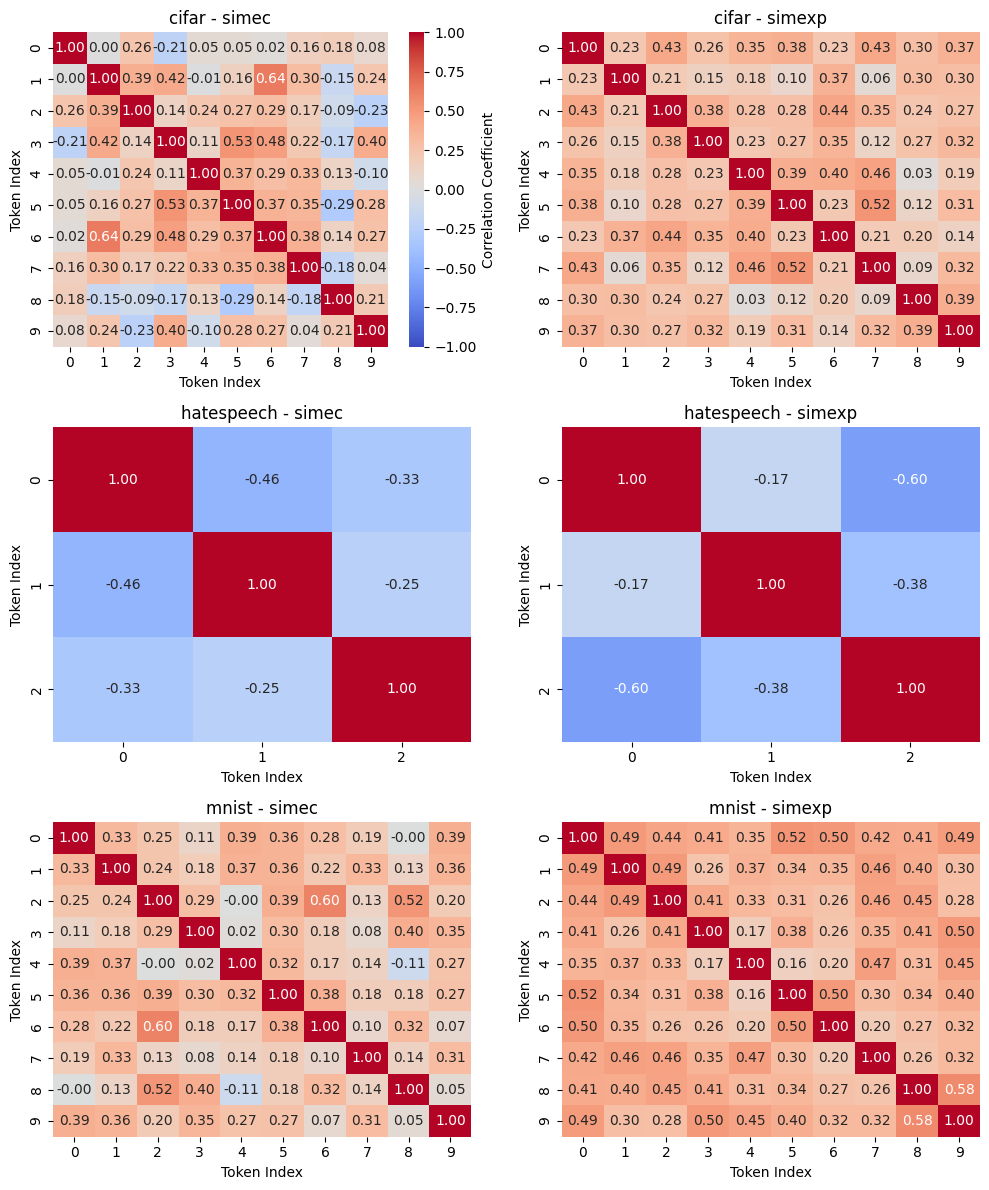

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Group by dataset and algorithm
group_cols = ["dataset", "algorithm"]
dataset_algo_groups = results[results["patch_option"] == "all"].groupby(group_cols)

# Set up layout
ncols = 2
nrows = int(np.ceil(len(dataset_algo_groups) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for idx, ((dataset, algorithm), group) in enumerate(dataset_algo_groups):
    ax = axes[idx]
    corr_matrices = []

    for (input_name, repetition, delta_multiplier, patch_option), input_group in group.groupby(["input_name", "repetition", "delta_multiplier", "patch_option"]):
        input_group = input_group.sort_values("iteration")
        prob_matrix = np.stack(input_group["embedding_pred_proba"].values).squeeze()
        try:
            stds = np.std(prob_matrix, axis=0)
            valid_cols = stds > 0
            filtered_matrix = prob_matrix[:, valid_cols]

            if filtered_matrix.shape[1] > 1:
                corr_matrix = np.corrcoef(filtered_matrix, rowvar=False)
                if not np.isnan(corr_matrix).all():
                    corr_matrices.append(corr_matrix)
        except Exception as e:
            print(f"Skipping {input_name} due to error: {e}")

    if corr_matrices:
        mean_corr_matrix = np.nanmean(np.stack(corr_matrices), axis=0)
        sns.heatmap(
            mean_corr_matrix,
            ax=ax,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",
            cbar=idx == 0,
            cbar_kws={"label": "Correlation Coefficient"}
        )
        ax.set_title(f"{dataset} - {algorithm}")
        ax.set_xlabel("Token Index")
        ax.set_ylabel("Token Index")
    else:
        ax.set_title(f"{dataset} - {algorithm}\nNo Valid Inputs")
        ax.axis("off")

# Handle extra axes if needed
for i in range(len(dataset_algo_groups), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Which sentences are changing?

In [14]:
results[
    (results["dataset"].apply(lambda x: np.any(x in ["hatespeech"]))) &
    (results["modified_image_diff"].apply(lambda x: np.any(np.array(x) > 0) if x is not None else False)) &
    (results["modified_image_pred"] == 2) &
    (results["original_image_pred"] == 1)
]

,dataset,delta_multiplier,patch_option,input_name,explored_patches,patch_attribution,number_explored_patches,save_each,algorithm,iteration,...,embedding_pred,modified_image_pred,distance,original_image_pred_proba,embedding_pred_proba,modified_image_pred_proba,modified_image,modified_image_diff,orig_vs_embed_diff,orig_vs_mod_diff
23981,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,440,...,2,2,"[2.434534291454667e-06, 0.00030344790254362993...","[0.026565988, 0.8223591, 0.15107489]","[0.0060556587, 0.03215017, 0.96179414]","[0.010929825, 0.10190504, 0.8871652]","[23033, 9152, 1996, 999, 23033, 2122, 9152, 20...",3,True,True
23993,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,560,...,2,2,"[1.194194323227232e-06, 1.2506405739024813e-06...","[0.026565988, 0.8223591, 0.15107489]","[0.0087153455, 0.029927755, 0.9613569]","[0.021001419, 0.3054312, 0.67356735]","[23033, 9152, 1996, 1029, 23033, 2015, 9152, 2...",2,True,True
23994,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,570,...,2,2,"[0.004172476803063235, 0.00010064844410032375,...","[0.026565988, 0.8223591, 0.15107489]","[0.009649635, 0.028340051, 0.9620103]","[0.01952933, 0.2135403, 0.7669304]","[23033, 9152, 1996, 1029, 1012, 2015, 9152, 20...",3,True,True
23995,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,580,...,2,2,"[0.00383865593332324, 0.003631602229014913, 3....","[0.026565988, 0.8223591, 0.15107489]","[0.009447936, 0.027745819, 0.9628062]","[0.03617461, 0.3092193, 0.6546061]","[23033, 9152, 1996, 1029, 1012, 1011, 9152, 20...",1,True,True
23996,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,590,...,2,2,"[0.0030300136092212566, 4.0918529126474236e-07...","[0.026565988, 0.8223591, 0.15107489]","[0.008509975, 0.027412374, 0.9640776]","[0.028809492, 0.23021689, 0.7409736]","[23033, 9152, 1996, 1012, 1012, 1011, 9152, 20...",1,True,True
23997,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,600,...,2,2,"[0.00012708008770152447, 0.0020567855875363856...","[0.026565988, 0.8223591, 0.15107489]","[0.007937695, 0.027563684, 0.9644986]","[0.018594211, 0.15152201, 0.82988375]","[23033, 9152, 1996, 1012, 1012, 1998, 9152, 20...",1,True,True
23999,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,620,...,2,2,"[0.001532541270020271, 1.0812314775479914e-06,...","[0.026565988, 0.8223591, 0.15107489]","[0.0070470553, 0.028605852, 0.96434706]","[0.015037669, 0.12304814, 0.86191416]","[23033, 9152, 1996, 999, 1012, 1996, 1012, 202...",6,True,True
24000,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,630,...,2,2,"[4.654189122442345e-05, 0.0015222002292915786,...","[0.026565988, 0.8223591, 0.15107489]","[0.007131105, 0.029489482, 0.96337944]","[0.01706473, 0.16138233, 0.821553]","[23033, 9152, 2003, 999, 1012, 1029, 1012, 202...",3,True,True
24001,hatespeech,10.0,q2,sentence_100811,"[38, 37, 6, 35, 22, 36, 21, 41, 8, 16, 32, 19,...","[1.0, 0.6569468975067139, 0.5002036690711975, ...",23,10,simexp,640,...,2,2,"[0.0017417695407144348, 0.0017925483853656553,...","[0.026565988, 0.8223591, 0.15107489]","[0.007602008, 0.030525692, 0.96187234]","[0.014943366, 0.118222825, 0.8668338]","[23033, 9152, 1998, 999, 1012, 1029, 1012, 202...",4,True,True
24004,hatespeech,10.0,q2,sente

Evaluating decoding on hatespeech

Which are the images where the top class has an increasing/decreasing probability?

In [11]:
records = []

group_cols = ["dataset", "patch_option", "delta_multiplier", "algorithm", "input_name", "repetition"]

for group_keys, group in results.groupby(group_cols):
    group = group.sort_values("iteration")
    rows = list(group.itertuples(index=False))
    if not rows:
        continue

    # Initialize previous preds
    if rows[0].dataset != "winobias":
        original_pred = rows[0].original_image_pred
    else:
        original_pred = np.argmax(rows[0].original_image_pred_proba)
    prev_proba_original_pred = rows[0].embedding_pred_proba[original_pred]
    prev_change_type = None

    # Iterate from second row onward
    for row in rows[1:]:
        curr_proba = row.embedding_pred_proba[original_pred]
        if prev_change_type is None:
            if curr_proba < prev_proba_original_pred:
                change_type = "-"
            elif curr_proba > prev_proba_original_pred:
                change_type = "+"
            else:
                change_type = "="
        else:
            if curr_proba < prev_proba_original_pred:
                change_type = "-"
            elif curr_proba > prev_proba_original_pred:
                change_type = "+"
            else:
                change_type = "="

            if change_type != prev_change_type:
                diff = curr_proba - prev_proba_original_pred
                records.append({
                    "type": change_type,
                    "dataset": row.dataset,
                    "algorithm": row.algorithm,
                    "delta_multiplier": row.delta_multiplier,
                    "patch_option": row.patch_option,
                    "input_name": row.input_name,
                    "repetition": row.repetition,
                    "iteration": row.iteration,
                    "diff": diff,
                })

        prev_change_type = change_type

        # Update trackers
        prev_proba_original_pred = curr_proba

# Create DataFrame from collected records
df_changes = pd.DataFrame.from_records(records)
pd.set_option('display.max_rows', 500)
df_changes

,type,dataset,algorithm,delta_multiplier,patch_option,input_name,repetition,iteration,diff
0,=,cifar,simec,0.1,all,img_1094,1,40,0.000000e+00
1,-,cifar,simec,0.1,all,img_1094,1,50,-4.768372e-07
2,+,cifar,simec,0.1,all,img_1094,1,60,4.768372e-07
3,-,cifar,simec,0.1,all,img_1094,1,80,-1.430511e-06
4,+,cifar,simec,0.1,all,img_1094,1,100,2.861023e-06
...,...,...,...,...,...,...,...,...,...
55163,+,winobias,simexp,10.0,target-word,sentence_93,3,760,1.130962e-02
55164,-,winobias,simexp,10.0,target-word,sentence_93,3,810,-2.252579e-03
55165,+,winobias,simexp,10.0,target-word,sentence_93,3,820,1.349449e-03
55166,-,winobias,simexp,10.0,target-word,sentence_93,3,840,-7.754326e-03


In [12]:
records = []

group_cols = ["dataset", "patch_option", "delta_multiplier", "algorithm", "input_name", "repetition"]

for group_keys, group in results.groupby(group_cols):
    group = group.sort_values("iteration")
    rows = list(group.itertuples(index=False))
    if not rows:
        continue

    # Initialize previous preds
    if rows[0].dataset != "winobias":
        original_pred = rows[0].original_image_pred
    else:
        original_pred = np.argmax(rows[0].original_image_pred_proba)
    prev_proba = rows[0].embedding_pred_proba[original_pred]

    # Start with no trend
    current_trend = None
    cumulative_diff = 0.0

    for row in rows[1:]:
        curr_proba = row.embedding_pred_proba[original_pred]
        diff = curr_proba - prev_proba

        # Determine direction
        if diff > 0:
            new_trend = "+"
        elif diff < 0:
            new_trend = "-"
        else:
            new_trend = "="

        # Handle direction changes only if meaningful
        if current_trend is None:
            current_trend = new_trend
            cumulative_diff = diff
        elif new_trend == current_trend or new_trend == "=":
            cumulative_diff += diff
        else:
            # Direction changed — check if reversal is stronger than previous trend
            if abs(diff) > abs(cumulative_diff):
                records.append({
                    "type": new_trend,
                    "dataset": row.dataset,
                    "algorithm": row.algorithm,
                    "delta_multiplier": row.delta_multiplier,
                    "patch_option": row.patch_option,
                    "input_name": row.input_name,
                    "repetition": row.repetition,
                    "iteration": row.iteration,
                    "diff": diff,
                })
                current_trend = new_trend
                cumulative_diff = diff
            else:
                cumulative_diff += diff  # Still within old trend

        prev_proba = curr_proba

# Create DataFrame
df_changes = pd.DataFrame.from_records(records)
df_changes

,type,dataset,algorithm,delta_multiplier,patch_option,input_name,repetition,iteration,diff
0,+,cifar,simec,0.1,all,img_1094,1,150,0.000007
1,-,cifar,simec,0.1,all,img_1094,1,170,-0.000005
2,+,cifar,simec,0.1,all,img_1094,1,650,0.000004
3,-,cifar,simec,0.1,all,img_1094,3,60,-0.000002
4,+,cifar,simec,0.1,all,img_1094,3,100,0.000004
...,...,...,...,...,...,...,...,...,...
2259,-,winobias,simexp,10.0,target-word,sentence_392,3,740,-0.017523
2260,+,winobias,simexp,10.0,target-word,sentence_93,1,90,0.009619
2261,+,winobias,simexp,10.0,target-word,sentence_93,2,130,0.020000
2262,-,winobias,simexp,10.0,target-word,sentence_93,2,160,-0.021921


In [13]:
group_cols = ["patch_option", "delta_multiplier", "algorithm", "dataset", "input_name"]
# --- Determine majority change per group ---
majority_summary = (
    df_changes
    .groupby(group_cols + ["type"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Determine majority type
majority_summary["majority_type"] = majority_summary[["+", "-"]].idxmax(axis=1)

# Optional: Rename columns for clarity
majority_summary = majority_summary.rename(columns={"+": "count_+", "-": "count_-", "=": "count_="})
pd.set_option('display.max_rows', 500)
# Show the result
majority_summary

type,patch_option,delta_multiplier,algorithm,dataset,input_name,count_+,count_-,majority_type
0,all,0.1,simec,cifar,img_1094,4,3,+
1,all,0.1,simec,cifar,img_13,4,5,-
2,all,0.1,simec,cifar,img_2697,2,4,-
3,all,0.1,simec,cifar,img_3831,8,8,+
4,all,0.1,simec,cifar,img_4514,2,2,+
5,all,0.1,simec,cifar,img_6524,7,5,+
6,all,0.1,simec,cifar,img_6845,5,3,+
7,all,0.1,simec,cifar,img_7905,9,8,+
8,all,0.1,simec,cifar,img_8599,7,6,+
9,all,0.1,simec,cifar,img_8907,5,4,+


In [14]:
# Count trend types (+, -) per algorithm
trend_counts = (
    df_changes.groupby(["algorithm", "patch_option", "delta_multiplier" ,"type"])
    .size()
    .unstack(fill_value=0)
    .sort_values(by="+", ascending=False)  # sort by positive trend count
)

display(trend_counts)

type                                       +    -
algorithm patch_option delta_multiplier          
simec     target-word  0.1               170  173
                       1.0               111  113
          one          0.1               111  114
          q2           0.1                93   98
          one          1.0                92   99
          target-word  10.0               58   56
simexp    all          10.0               55   70
simec     all          0.1                53   48
          one          10.0               41   42
          all          1.0                31   29
          q2           1.0                28   40
simexp    q2           1.0                27   26
                       10.0               26   37
                       0.1                26   23
                       5.0                23   27
          one          1.0                21   25
simec     one          5.0                18   20
simexp    all          5.0                16   29
          one          0.1                15   11
                       10.0               15    8
          target-word  0.1                12    8
          all          1.0                11   16
simec     q2           5.0                 9    9
simexp    all          0.1                 9   12
          target-word  10.0                7    6
simec     all          10.0                7   10
simexp    one          5.0                 6    3
simec     all          5.0                 6    4
          q2           10.0                5    6

In [15]:
# Average iteration of trend switches (could also look at std deviation)
avg_iter_per_trend = (
    df_changes.groupby(["algorithm", "type"])["iteration"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .sort_values(["algorithm", "type"])
)

display(avg_iter_per_trend)

,algorithm,type,mean,std,count
0,simec,+,282.671068,273.454490,833
1,simec,-,277.002323,268.935507,861
2,simexp,+,279.925651,279.010769,269
3,simexp,-,300.960133,290.162159,301


In [16]:
# Define grouping columns (experiment-level identifiers)
group_cols = ["dataset", "patch_option", "delta_multiplier", "algorithm", "input_name", "repetition"]

# Assume each experiment has 100 iterations saved (one every 10 iterations for 1000 total iterations)
total_iterations = 101

# Group df_changes by the experiment identifiers plus the change type and count the number of unique iterations
change_summary = (
    df_changes.groupby(group_cols + ["type"])["iteration"]
    .nunique()  # count unique iterations where a change was recorded
    .reset_index(name="change_count")
)

# Pivot the table so that each type ("+", "-", "=") becomes its own column
pivot_summary = change_summary.pivot_table(
    index=group_cols,
    columns="type",
    values="change_count",
    fill_value=0
).reset_index()

# Rename the columns for clarity if present
if "+" in pivot_summary.columns:
    pivot_summary = pivot_summary.rename(columns={"+": "increase_count"})
if "-" in pivot_summary.columns:
    pivot_summary = pivot_summary.rename(columns={"-": "decrease_count"})
if "=" in pivot_summary.columns:
    pivot_summary = pivot_summary.rename(columns={"=": "equal_count"})

# In case a type is missing, add it with 0
for col in ["increase_count", "decrease_count", "equal_count"]:
    if col not in pivot_summary.columns:
        pivot_summary[col] = 0

# Calculate percentage for each change type per experiment
pivot_summary["pct_increase"] = (pivot_summary["increase_count"] / total_iterations) * 100
pivot_summary["pct_decrease"] = (pivot_summary["decrease_count"] / total_iterations) * 100
pivot_summary["pct_equal"] = (pivot_summary["equal_count"] / total_iterations) * 100

# Display the final summary DataFrame
pivot_summary

type,dataset,patch_option,delta_multiplier,algorithm,input_name,repetition,increase_count,decrease_count,equal_count,pct_increase,pct_decrease,pct_equal
0,cifar,all,0.1,simec,img_1094,1,2.0,1.0,0,1.980198,0.990099,0.0
1,cifar,all,0.1,simec,img_1094,3,2.0,2.0,0,1.980198,1.980198,0.0
2,cifar,all,0.1,simec,img_13,1,0.0,1.0,0,0.000000,0.990099,0.0
3,cifar,all,0.1,simec,img_13,2,2.0,2.0,0,1.980198,1.980198,0.0
4,cifar,all,0.1,simec,img_13,3,2.0,2.0,0,1.980198,1.980198,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
691,winobias,target-word,10.0,simexp,sentence_25,3,0.0,1.0,0,0.000000,0.990099,0.0
692,winobias,target-word,10.0,simexp,sentence_392,2,0.0,1.0,0,0.000000,0.990099,0.0
693,winobias,target-word,10.0,simexp,sentence_392,3,0.0,1.0,0,0.000000,0.990099,0.0
694,winobias,target-word,10.0,simexp,sentence_93,1,1.0,0.0,0,0.990099,0.000000,0.0


In [17]:
high_level_summary = (
    pivot_summary
    .groupby(["algorithm", "patch_option", "delta_multiplier"])
    .agg(
        mean_pct_increase=("pct_increase", "mean"),
        mean_pct_decrease=("pct_decrease", "mean"),
        mean_pct_equal=("pct_equal", "mean"),
        std_pct_increase=("pct_increase", "std"),
        std_pct_decrease=("pct_decrease", "std"),
        std_pct_equal=("pct_equal", "std"),
        num_experiments=("pct_equal", "count")  # or any column, since they're all same length
    )
    .reset_index()
)

# Show the summarized result
high_level_summary

,algorithm,patch_option,delta_multiplier,mean_pct_increase,mean_pct_decrease,mean_pct_equal,std_pct_increase,std_pct_decrease,std_pct_equal,num_experiments
0,simec,all,0.1,2.018279,1.827875,0.0,1.297922,1.036244,0.0,26
1,simec,all,1.0,1.334481,1.248386,0.0,0.767432,1.043450,0.0,23
2,simec,all,5.0,0.742574,0.495050,0.0,0.458327,0.529230,0.0,8
3,simec,all,10.0,0.630063,0.900090,0.0,0.667525,0.693712,0.0,11
4,simec,one,0.1,2.442244,2.508251,0.0,1.798604,1.823210,0.0,45
5,simec,one,1.0,1.718662,1.849430,0.0,1.505959,1.345808,0.0,53
6,simec,one,5.0,0.848656,0.942951,0.0,0.648172,0.583755,0.0,21
7,simec,one,10.0,0.902090,0.924092,0.0,0.694425,0.743324,0.0,45
8,simec,q2,0.1,1.879168,1.980198,0.0,1.644937,1.678795,0.0,49
9,simec,q2,1.0,0.894283,1.277547,0.0,0.934227,0.855297,0.0,31


In [18]:
# Define the group columns to flatten over iterations and repetitions
group_cols_flat = ["dataset", "patch_option", "delta_multiplier", "algorithm", "input_name"]

# Count occurrences of each change type
type_counts = (
    df_changes
    .groupby(group_cols_flat + ["type"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"-": "- count", "+": "+ count", "=": "= count"})
)

# Compute mean diff for each change type
type_means = (
    df_changes
    .groupby(group_cols_flat + ["type"])["diff"]
    .mean()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"-": "mean -", "+": "mean +", "=": "mean ="})
)

# Compute sumn diff for each change type
type_sums = (
    df_changes
    .groupby(group_cols_flat + ["type"])["diff"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"-": "sum -", "+": "sum +", "=": "sum ="})
)

# Merge counts and means
summary_df = pd.merge(type_counts, type_means, on=group_cols_flat)

# Merge the result with sums
summary_df = pd.merge(summary_df, type_sums, on=group_cols_flat)
pd.set_option('display.max_rows', 500)
# Display the final summary
summary_df

type,dataset,patch_option,delta_multiplier,algorithm,input_name,+ count,- count,mean +,mean -,sum +,sum -
0,cifar,all,0.1,simec,img_1094,4,3,5.245209e-06,-3.019969e-06,2.098083e-05,-9.059906e-06
1,cifar,all,0.1,simec,img_13,4,5,5.245209e-06,-7.247925e-06,2.098083e-05,-3.623962e-05
2,cifar,all,0.1,simec,img_2697,2,4,4.053116e-06,-5.125999e-06,8.106232e-06,-2.050400e-05
3,cifar,all,0.1,simec,img_3831,8,8,6.616116e-06,-4.649162e-06,5.292892e-05,-3.719330e-05
4,cifar,all,0.1,simec,img_4514,2,2,5.722046e-06,-8.106232e-06,1.144409e-05,-1.621246e-05
5,cifar,all,0.1,simec,img_6524,7,5,5.585807e-06,-7.820129e-06,3.910065e-05,-3.910065e-05
6,cifar,all,0.1,simec,img_6845,5,3,3.242493e-06,-4.609426e-06,1.621246e-05,-1.382828e-05
7,cifar,all,0.1,simec,img_7905,9,8,3.655751e-06,-4.768372e-06,3.290176e-05,-3.814697e-05
8,cifar,all,0.1,simec,img_8599,7,6,6.948198e-06,-5.642573e-06,4.863739e-05,-3.385544e-05
9,cifar,all,0.1,simec,img_8907,5,4,7.057190e-06,-7.152557e-06,3.528595e-05,-2.861023e-05


In [19]:
# Define the group columns to flatten over iterations and repetitions
group_cols_flat = ["patch_option", "delta_multiplier", "algorithm"]

# Count occurrences of each change type
type_counts = (
    df_changes
    .groupby(group_cols_flat + ["type"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"-": "- count", "+": "+ count", "=": "= count"})
)

# Compute mean diff for each change type
type_means = (
    df_changes
    .groupby(group_cols_flat + ["type"])["diff"]
    .mean()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"-": "mean -", "+": "mean +", "=": "mean ="})
)

# Compute sumn diff for each change type
type_sums = (
    df_changes
    .groupby(group_cols_flat + ["type"])["diff"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"-": "sum -", "+": "sum +", "=": "sum ="})
)

# Merge counts and means
summary_df = pd.merge(type_counts, type_means, on=group_cols_flat)

# Merge the result with sums
summary_df = pd.merge(summary_df, type_sums, on=group_cols_flat)

# Display the final summary
summary_df

summary_df

type,patch_option,delta_multiplier,algorithm,+ count,- count,mean +,mean -,sum +,sum -
0,all,0.1,simec,53,48,0.000005,-0.000006,0.000287,-0.000273
1,all,0.1,simexp,9,12,0.001643,-0.001251,0.014784,-0.015007
2,all,1.0,simec,31,29,0.000055,-0.000064,0.001716,-0.001861
3,all,1.0,simexp,11,16,0.011013,-0.013417,0.121138,-0.214669
4,all,5.0,simec,6,4,0.000357,-0.000245,0.002142,-0.000979
5,all,5.0,simexp,16,29,0.062667,-0.059893,1.002678,-1.736905
6,all,10.0,simec,7,10,0.000854,-0.000595,0.005980,-0.005953
7,all,10.0,simexp,55,70,0.130400,-0.141658,7.172019,-9.916047
8,one,0.1,simec,111,114,0.000003,-0.000003,0.000320,-0.000331
9,one,0.1,simexp,15,11,0.000052,-0.000038,0.000782,-0.000422
